In [14]:
from konlpy.tag import *
import datetime
from IPython.display import display

import re
import numpy as np
import pandas as pd
from pprint import pprint
from konlpy.tag import Hannanum

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

stopwords는 불필요한 단어, 즉 조사나 관사들을 없애는 툴이다.

In [15]:
stop_words = list(pd.read_csv('kor_stop_words.csv').T.iloc[:1,:].values[0])
stop_words[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

# 전체 데이터프레임 병합하기

In [19]:
df = pd.read_csv('crawling_process/concat_data.csv')
df.tail()

,click,content,time,title
9198,3190,▲ 이더리움 비트코인 비트코인과 함께 이더리움에 관심이 쏠리고 있다한 매체 보도에 ...,05-25,비트코인 이어 이더리움도 관심 스마트 콘트랙트 전자계약이 뭐길래
9199,2706,비트코인 © AFP뉴스1대표적인 전자화폐 비트코인의 랠리가 눈부시다 올 들어서만 그...,05-25,비트코인보다 눈부신 이더리움…올해 들어 2300 급등
9200,3067,Photo ⓒpixabay▲비트코인Bitcoin이 화제다 비트코인은 2009년 나...,05-25,비트코인 이더리움 가상화폐 수요 급증 이유는
9201,2801,사진게티이미지뱅크 비트코인 가상화폐비트코인 이더리움 등 가상화폐의 가격이 계속해서 ...,05-25,몸값 오르는 가상화폐…비트코인·이더리움 뭐길래
9202,2341,비트코인이 2000달러를 돌파한지 닷새만에 또다시 최고치를 새로 썼다고 24일현지시...,05-25,비트코인 2500달러 또 사상최고치


In [20]:
df.fillna('0',inplace=True)

In [21]:
df['content'] = [i.replace('  ','') for i in df['content'].values]

________

In [22]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# # ▶ 이후로 나온 단어들은 기사의 author 에 관한 내용으로 지워준다.
# data = [data[i][:re.search('▶',data[i]).start()] if '▶' in i else data[i] for i in range(len(data))]

pprint(data[:1])

['넥시빗에서 이번에 이벤트 정말 크게 하네요이번 기회에 핸드폰 아이폰으로 바꿔야 겠어요도전 httpnatenewscCnm']


# tokenization process

- 정규식 표현을 통해서 문장 내에 이메일과 기타 특수 문자들을 없애주었지만, 여전히 난잡해보인다.
- LDA 알고리즘을 사용하기 위해서는, 문장들을 단어들의 묶음으로 변환시켜주는 과정이 필요하다.
- 이러한 과정을 Tokenization 이라고 한다.

In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        # deacc=True removes punctuations
        # 구두점(말끝에 찍는 쉼표나 점들을 의미) 을 없애주는 것이다.

data_words = list(sent_to_words(data))

print(data_words[:1])

[['넥시빗에서', '이번에', '이벤트', '정말', '크게', '하네요이번', '기회에', '핸드폰', '아이폰으로', '바꿔야', '겠어요도전']]


### Bigram , Trigram 모델 만들기
- Bigram : 문서에서 함께 자주 등장하는 2개의 단어
- Trigram : 문서에서 함께 자주 등장하는 3개의 단어
- ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.
- Phrases : 모델을 빌드한다.
- min_count , threshold : Pharases 의 중요한 두 개의 파라미터
    - min_count (float, optional) : Ignore all words and bigrams with total collected count lower than this value.
    - threshold (float, optional) : Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/hskimim/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['넥시빗에서', '이번에', '이벤트', '정말', '크게', '하네요이번', '기회에', '핸드폰', '아이폰으로', '바꿔야', '겠어요도전']


In [25]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [26]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# nlp = spacy.load('en', disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_lemmatized = data_words_bigrams.copy()

print(data_lemmatized[:1])

[['넥시빗에서', '이번에', '이벤트', '정말', '크게', '하네요이번', '기회에', '핸드폰', '아이폰으로', '바꿔야', '겠어요도전']]


- LDA 모델에 들어가야 하는 두 가지 입력변수는 딕셔너리와(id2word) 코퍼스(corpus)이다.
- gensim 은 문서 내에 있는 단어별로 유니크한 아이디를 할당해준다.
- 아래의 각각의 엘리먼트 튜플당 의미하는 것은 [word_id,word_frequency] 이다.

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


만약 해당 id에 속한 단어를 보고싶으면

In [28]:
id2word[0]

'겠어요도전'

위의 표는 컴퓨터가 읽기 쉽게끔 만들어준 것이고, Counter 객체처럼 사람이 읽기 쉽게 만든 것은 아래와 같다.

In [29]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('겠어요도전', 1),
  ('기회에', 1),
  ('넥시빗에서', 1),
  ('바꿔야', 1),
  ('아이폰으로', 1),
  ('이번에', 1),
  ('이벤트', 1),
  ('정말', 1),
  ('크게', 1),
  ('하네요이번', 1),
  ('핸드폰', 1)]]

여태까지 해온 것이 LDA 모델 생성에 필요한 것들을 전부 한 것이다. 코퍼스와 딕셔너리를 생성한 것에 더해서, 우리는 몇 개의 토픽을 할당할 것인지에 대한 결정을 해주어야 한다.

- alpha , eta 는 토픽들의 떨어진 정도(sparsity)에 영향을 끼치는 하이퍼 파라미터이다. 도큐먼트에 따르면, 디폴트값은 1.0/num_topics prior 이다.
- chunksize 는 각각의 training chunk 에 사용될 문서의 갯수를 의미한다. 확실하지는 않지만, batch_size 와 유사한 의미를 갖는 것로 해석된다.

    - IN ADDITION : Text chunking, also referred to as shallow parsing, is a task that follows Part-Of-Speech Tagging and that adds more structure to the sentence. The result is a grouping of the words in “chunks”.


In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

위의 모델을 통해 반환되는 것은 토픽의 수는 20개이고 각각의 키워드(단어들의 집합)와 키워드들 간의 조합이 특정한 토픽의 가중치를 정해주는데 기여하는 것이다.

- lda_model 객체에 print_topics 메소드를 operating 하면, 각각의 키워드들이 토픽에 기여하는 가중치(importance)를 알 수 있다.
- 0부터 19까지 총 20개에 해당하는 토픽이 있는 것을 알 수 있고, 각각의 토픽에 위치해있는 키워드들과 이들 키워드들이 해당 토픽에서 가지는 중요도가 순서대로 나와있다.

In [31]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"the" + 0.008*"and" + 0.007*"of" + 0.007*"to" + 0.006*"bitcoin" + '
  '0.005*"segwit" + 0.004*"in" + 0.004*"for" + 0.004*"is" + 0.003*"as"'),
 (1,
  '0.021*"비트코인" + 0.016*"가상화폐" + 0.006*"비트코인은" + 0.006*"있는" + 0.006*"가격이" + '
  '0.006*"비트코인의" + 0.006*"이더리움" + 0.005*"비트코인을" + 0.005*"비트코인이" + 0.004*"같은"'),
 (2,
  '0.005*"리플" + 0.005*"따르면" + 0.005*"비트코인" + 0.003*"기록했다" + 0.003*"억달러를" + '
  '0.003*"비트코인bitcoin" + 0.003*"달러를_기록했다" + 0.003*"브라이언_켈리" + 0.003*"최고경영자는" + '
  '0.003*"보도했다비트코인"'),
 (3,
  '0.008*"대한" + 0.006*"관련" + 0.006*"암호화폐" + 0.006*"따르면" + 0.004*"있다고" + '
  '0.004*"것이라고" + 0.004*"중국" + 0.004*"지난" + 0.004*"거래" + 0.004*"금융"'),
 (4,
  '0.023*"블록체인" + 0.006*"있는" + 0.006*"통해" + 0.005*"기술을" + 0.004*"다양한" + '
  '0.004*"디지털" + 0.004*"기반으로" + 0.004*"기반" + 0.003*"기술" + 0.003*"위해"')]


In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.250579002602915

Coherence Score:  0.5208918096675224


pyLDAvis 만큼 jupyter notebook에서 LDA랄 잘 작동하면서 시각화하는 툴도 없다.

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      37.676397        1       1  0.242790 -0.175018
3      29.606871        1       2  0.101374  0.140714
4      22.230816        1       3  0.015201  0.181021
0       5.465395        1       4 -0.220455 -0.062490
2       5.020520        1       5 -0.138910 -0.084227, topic_info=       Category         Freq           Term        Total  loglift  logprob
term                                                                      
72      Default  9597.000000           비트코인  9597.000000  30.0000  30.0000
69      Default  6771.000000           블록체인  6771.000000  29.0000  29.0000
2989    Default  7201.000000           가상화폐  7201.000000  28.0000  28.0000
2487    Default  2298.000000            따르면  2298.000000  27.0000  27.0000
1932    Default  2828.000000          비트코인은  2828.000000  26.0000  26.0000
957     Default  2650.000000            가격이  2650.000000  25.0000  25.0000
2391    Default  2501.000000          비트코인의  2501.000000  24.0000  24.0000
872     Default  2334.000000             관련  2334.000000  23.0000  23.0000
88      Default  2006.000000           암호화폐  2006.000000  22.0000  22.0000
6322    Default  2294.000000          비트코인을  2294.000000  21.0000  21.0000
3318    Default   762.000000            the   762.000000  20.0000  20.0000
2090    Default  1377.000000            기술을  1377.000000  19.0000  19.0000
2307    Default  2101.000000          비트코인이  2101.000000  18.0000  18.0000
54      Default  4439.000000             대한  4439.000000  17.0000  17.0000
98      Default  2936.000000           이더리움  2936.000000  16.0000  16.0000
6953    Default   527.000000            and   527.000000  15.0000  15.0000
233     Default  3086.000000             통해  3086.000000  14.0000  14.0000
7459    Default  1546.000000            가격은  1546.000000  13.0000  13.0000
774     Default  1425.000000            다양한  1425.000000  12.0000  12.0000
1956    Default  1192.000000             일본  1192.000000  11.0000  11.0000
3430    Default  1933.000000            디지털  1933.000000  10.0000  10.0000
501     Default  1524.000000             중국  1524.000000   9.0000   9.0000
2627    Default  1050.000000           기반으로  1050.000000   8.0000   8.0000
1908    Default  1010.000000             기반  1010.000000   7.0000   7.0000
6979    Default   475.000000             of   475.000000   6.0000   6.0000
12377   Default  1336.000000          가상화폐를  1336.000000   5.0000   5.0000
3719    Default  1066.000000             규제  1066.000000   4.0000   4.0000
6993    Default   435.000000             to   435.000000   3.0000   3.0000
3206    Default  1451.000000             금융  1451.000000   2.0000   2.0000
3988    Default  2854.000000             지난  2854.000000   1.0000   1.0000
...         ...          ...            ...          ...      ...      ...
8370     Topic5    74.741261        비트코인_캐시    75.287325   2.9844  -6.6853
24275    Topic5    70.589248           나타내고    71.130881   2.9840  -6.7424
172825   Topic5   153.046982         상승_곡선을   154.224311   2.9840  -5.9686
139309   Topic5    63.492810           만원선을    64.040116   2.9831  -6.8484
1952     Topic5    72.603206           이데일리    73.238117   2.9829  -6.7143
18103    Topic5    58.721966            캐시는    59.262402   2.9825  -6.9265
69973    Topic5    57.098662       달러에_거래되고    57.638726   2.9822  -6.9545
45529    Topic5    59.366526             위는    59.938765   2.9820  -6.9156
73543    Topic5    55.665286          전일_대비    56.203194   2.9820  -6.9800
7751     Topic5    55.288434           하루만에    55.834386   2.9818  -6.9868
90278    Topic5    60.304857         있다가상화폐    60.908429   2.9817  -6.8999
5925     Topic5    63.671315             피싱    64.308643   2.9817  -6.8456
8867     Topic5    58.973964            bch    59.580212   2.9814  -6.9222
26578    Topic5    53.309558           나오면서    53.859913   2.9814  -7.0232
5875     Topic5    51.725142             급등    52.2690

- Gensim 의 LDA 알고리즘보다 Mallet 버젼이 더 나은 퀄리티를 보여준다.
- https://www.machinelearningplus.com/wp-content/uploads/2018/03/mallet-2.0.8.zip 깔고 해당 경로를 아래에 넣어주면 된다.

# Q. What is diff between Mallet and LDA_model ?

It's not that one is more complete than the other it is more a question of one having some stuff the other doesn't and vice versa. It also a question of intended audience and purpose.

Mallet is a Java based machine learning toolkit that aims to provide robust and fast implementations for various natural language processing tasks.

NLTK is built using Python and comes with a lot of extra stuff like corpora such as WordNet. NLTK is aimed more at people learning NLP, and as such is used more as a learning platform and perhaps less as an engineering solution.

In my opinion the main difference between the two is that NLTK is better positioned as a learning resource for people interested in machine learning and NLP as it comes with a whole ton of documentation, examples, corpora etc. etc.

Mallet is more aimed at researchers and practitioners that work in the field and already know what they want to do. It comes with less documentation (although it has good examples and the API is well documented) compared to NLTK's extensive collection of general NLP stuff.

UPDATE: Good articles describing these would be the Mallet docs and examples at http://mallet.cs.umass.edu/ - the sidebar has links to sequence tagging, topic modelling etc.

and for NLTK the NLTK book Natural Language Processing with Python is a good introduction both to NLTK and to NLP.

The inference algorithms in Mallet and Gensim are indeed different. Mallet uses Gibbs Sampling which is more precise than Gensim's faster and online Variational Bayes. There is a way to get relatively performance by increasing number of passes.


In [22]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/hskimim/Documents/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))


[(0,
  [('비트코인', 0.027623536766943887),
   ('가상화폐', 0.008592252576853154),
   ('비트코인을', 0.006190205901466729),
   ('가격이', 0.005651390636953678),
   ('비트코인은', 0.005421057394108405),
   ('현재', 0.005038539687240361),
   ('지난', 0.004594325576038762),
   ('비트코인이', 0.004561420827060865),
   ('이더리움', 0.0045038375163495474),
   ('것으로', 0.004479158954616125)]),
 (1,
  [('블록체인', 0.03641037272246163),
   ('있는', 0.008743479246994784),
   ('통해', 0.007227640432448779),
   ('기술을', 0.0055908369244726695),
   ('기술', 0.005072956830725032),
   ('다양한', 0.004619339230362138),
   ('위해', 0.004475693656913888),
   ('기반', 0.004211083390035533),
   ('디지털', 0.003534437136160883),
   ('모든', 0.003447493762757995)]),
 (2,
  [('암호화폐', 0.035044202760287475),
   ('통해', 0.006123876759251688),
   ('따르면', 0.005642325619429226),
   ('암호화폐를', 0.00560143920189713),
   ('거래소', 0.0051925750265761714),
   ('중국', 0.004588364634157422),
   ('금융', 0.004533849410781294),
   ('관련', 0.00450659179909323),
   ('밝혔다', 0.004361217870090

In [23]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4368632464144686


#### LDA 에서 최적의 토픽 갯수 찾기
- 많은 LDA 모델을 토픽 갯수(k)를 다르게 해서, 많이 시행해본 후, Coherance value 가 가장 높은 것을 선택한다.
- 높은 Coherance Value 를 가지는 k를 선택하는 것은 유의미하고, 세부적인 토픽을 할당할 수 있게끔 한다.
- 여러개의 토픽에 키워드가 많이 중첩되면, 이것은 k를 너무 높게 할당했다는 신호가 될 수 있다.
- compute_coherence_values라는 메소드는 다수의 LDA 모델에 대한 Coherance value 를 알려준다.

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

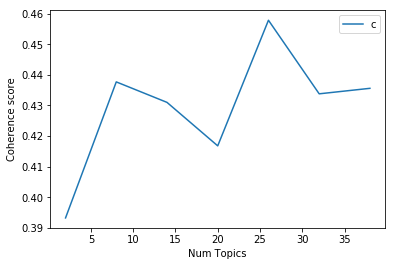

In [35]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3932
Num Topics = 8  has Coherence Value of 0.4377
Num Topics = 14  has Coherence Value of 0.431
Num Topics = 20  has Coherence Value of 0.4168
Num Topics = 26  has Coherence Value of 0.4578
Num Topics = 32  has Coherence Value of 0.4338
Num Topics = 38  has Coherence Value of 0.4356


# 토픽이 26개일 때,  coherance value 가 maximized 된다.

#### 해당 문장에서 지배적인 토픽을 찾기
- 토픽 모델링의 주요 활용점은 해당 문서의 토픽이 무엇이냐에 관한 것이다.
- 이를 알아내기 위해서는 해당 문서에서 가장 기여를 많이 한, 즉 중요도가 가장 높은 토픽의 넘버를 찾아야 한다.
- format_topics_sentences() 메소드는 보여지는 테이블로 훌륭하게 정보를 병합해준다.

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet , corpus=corpus, texts=data)

#ldamallet 파라미터를 optimal_params 로 바꿔주는 시퀀스로 업데이트할 것!

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2477,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",넥시빗에서 이번에 이벤트 정말 크게 하네요이번 기회에 핸드폰 아이폰으로 바꿔야 겠어...
1,1,2.0,0.3830,"암호화폐, 통해, 따르면, 암호화폐를, 거래소, 중국, 금융, 관련, 밝혔다, 있다고",안녕하세요 최고로 안전한 암호화폐 거래소 트래빗입니다11월 5일 암호화폐블록체인 시...
2,2,4.0,0.2561,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",에어드랍받으려고 지난주 목요일인가 뮤지카 텔방 들어가있는데상장얘기는 계속나오는데 계...
3,3,1.0,0.3093,"블록체인, 있는, 통해, 기술을, 기술, 다양한, 위해, 기반, 디지털, 모든",사이버 마일스CMT는 기존 100만명 이상의 회원이 등록되어 있는 5miles의 R...
4,4,4.0,0.2920,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",저는 예상 되는곳 2곳에 이더 넣어놓고 홀더중이긴한데뮤지카 대기타시는 분들 대충 각...
5,5,4.0,0.3598,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",◆ 심볼CMT◆ 유형C2C 전자상거래 플랫폼◆ 백서◆ 위치홍콩◆ 총 발행량10억개◆...
6,6,1.0,0.2619,"블록체인, 있는, 통해, 기술을, 기술, 다양한, 위해, 기반, 디지털, 모든",요즘 여기저기서 이거 정보가 자주 보이더라고요 큐포라뷰티산업과 블록체인을 접목했다고...
7,7,4.0,0.3084,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",레퍼럴 없는 순수 소개입니다약 3만원 가량의 코인을 획득가능해요세계최초 블록체인기반...
8,8,4.0,0.2203,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",Benepit을 만나기 위해나는 그토록 힘들게 버티며힘든 전장에 뛰어들었나보다너만 믿는다
9,9,0.0,0.2320,"비트코인, 가상화폐, 비트코인을, 가격이, 비트코인은, 현재, 지난, 비트코인이, ...",존버하려다가 빠르게 매도했는데키야 딱 2주만에 박살나는거 보고소름 돋더라요ㅎㅎ


________________

#### 각각의 토픽을 대표하는 문서찾기
- 가끔 토픽 키워드(단어)는 단지 토픽들을 구성하는 것에 그치지 않는 경우가 있다.
- 토픽을 이해하는 것을 넘어서, 토픽을 형성하는데 가장 많은 기여를 한 문서를 찾아낼 수도 있다.

In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8289,"비트코인, 가상화폐, 비트코인을, 가격이, 비트코인은, 현재, 지난, 비트코인이, ...",글로벌 비트코인 가격이 이틀째 8400달러한화 약 908만8800원선을 횡보했다 해...
1,1.0,0.7465,"블록체인, 있는, 통해, 기술을, 기술, 다양한, 위해, 기반, 디지털, 모든",과학기술정보통신부와 한국인터넷진흥원KISA은 블록체인 우수 활용사례 발굴을 위한 시...
2,2.0,0.6312,"암호화폐, 통해, 따르면, 암호화폐를, 거래소, 중국, 금융, 관련, 밝혔다, 있다고",헤지펀드의 귀재 조지 소로스의 예언이 적중하고 있다최근 암호화폐가상화폐 회사에 투자...
3,3.0,0.7721,"가상화폐, 대한, 거래소, 있는, 관련, 국내, 대해, 가상통화, 정부가, 경우",정부가 13일 가상통화 투기과열과 가상통화를 이용한 범죄행위를 막기 위해 긴급대책을...
4,4.0,0.9662,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",시간이 되는데로 핵심 내용을 번역하겠습니다Hudson Vitalik whats yo...


#### 문서를 넘어선 토픽 분배
- 마지막으로 우리는 해당 정보에서 어떤 것들이 가장 많이 거론되었는지를 토픽의 크기(volume)과 분포(distribution)로 이해할 수 있게 된다.

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.iloc[:10]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",2245.0,0.2439
1,2.0,"암호화폐, 통해, 따르면, 암호화폐를, 거래소, 중국, 금융, 관련, 밝혔다, 있다고",1499.0,0.1629
2,4.0,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",1651.0,0.1794
3,1.0,"블록체인, 있는, 통해, 기술을, 기술, 다양한, 위해, 기반, 디지털, 모든",1213.0,0.1318
4,4.0,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",2595.0,0.2820
5,4.0,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",NaN,NaN
6,1.0,"블록체인, 있는, 통해, 기술을, 기술, 다양한, 위해, 기반, 디지털, 모든",NaN,NaN
7,4.0,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",NaN,NaN
8,4.0,"있습니다, 대한, 많은, 있는, 대해, 것을, 현재, 같은, 많이, 모든",NaN,NaN
9,0.0,"비트코인, 가상화폐, 비트코인을, 가격이, 비트코인은, 현재, 지난, 비트코인이, ...",NaN,NaN
